In [49]:
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, Flatten, Dense, MaxPooling2D, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import LearningRateScheduler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf
import cv2
import os
import pandas as pd
import warnings

warnings.filterwarnings('ignore')

In [50]:

DATASET_PATH = r"./dataset/"
IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256
EPOCHS = 30
BATCH_SIZE = 32
SEED = 42
dataset_folders = []
total = 0
print(f"There are {len(os.listdir(DATASET_PATH))} folder in dataset.")
for path in sorted(os.listdir(DATASET_PATH)):
    print(f"\t-There are {len(os.listdir(DATASET_PATH + path))} images in {path} folder.")
    total += len(os.listdir(DATASET_PATH + path))
    folder_path = DATASET_PATH + path
    dataset_folders.append(folder_path)

df = pd.DataFrame(0,
                  columns=['paths',
                           'class-label'],
                  index=range(total))
i = 0
for p, path in enumerate(dataset_folders):
    for sub_path in sorted(os.listdir(path)):
        df.iloc[i, 0] = path + "/" + sub_path
        df.iloc[i, 1] = p
        i += 1
print(df.sample(frac=1, random_state=SEED).head(10))

There are 4 folder in dataset.
	-There are 300 images in 1_normal folder.
	-There are 100 images in 2_cataract folder.
	-There are 101 images in 2_glaucoma folder.
	-There are 100 images in 3_retina_disease folder.
                                         paths  class-label
110              ./dataset/1_normal/NL_111.png            0
419      ./dataset/2_glaucoma/Glaucoma_020.png            2
565  ./dataset/3_retina_disease/Retina_065.png            3
77               ./dataset/1_normal/NL_078.png            0
181              ./dataset/1_normal/NL_182.png            0
284              ./dataset/1_normal/NL_285.png            0
10               ./dataset/1_normal/NL_011.png            0
469      ./dataset/2_glaucoma/Glaucoma_070.png            2
78               ./dataset/1_normal/NL_079.png            0
349      ./dataset/2_cataract/cataract_050.png            1


In [51]:
#normalizes the histogram of images
def normalize_histograms(img):
    image_copy = img.copy()
    for i in range(3):
        imi = img[:, :, i]
        minval = np.min(imi)
        maxval = np.max(imi)
        imrange = maxval - minval
        # imi-minval will turn the color range between 0-imrange, and the scaling will stretch the range between 0-255
        image_copy[:, :, i] = (255 / (imrange + 0.0001) * (imi - minval))
    return image_copy


#Cropping image to avoid from unuseful black areas
def deleteBlackAreas(filename):
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
    img = cv2.imread(filename)  #read image from file
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
    _, thresh = cv2.threshold(gray, 10, 255, cv2.THRESH_BINARY)  # turn it into a binary image
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # find contours
    if len(contours) != 0:
        #find the biggest area
        cnt = max(contours, key=cv2.contourArea)

        #find the bounding rect
        x, y, w, h = cv2.boundingRect(cnt)

        crop = img[y:y + h, x:x + w]  # crop image
        crop1 = cv2.cvtColor(cv2.resize(crop, image_size, interpolation=cv2.INTER_AREA),
                             cv2.COLOR_BGR2RGB)  # resize to image_size and change color space from BGR to RGB for matplotlib
        return crop1
    else:
        return cv2.resize(img, image_size, interpolation=cv2.INTER_AREA)

In [52]:
def create_dataset(df, mode=0):
    # Creating dataset
    images = {0: [], 1: []}
    labels = {0: [], 1: []}
    limit = len(df) - len(df) // 5
    index = 0
    df = df.sample(frac=1, random_state=SEED)
    for i in range(len(df)):
        if (i + 1) >= limit:
            index = 1
        filename = df.iloc[i]["paths"]
        if i % 100 == 0:
            print(f"{i}. step---> {filename}")
        img = deleteBlackAreas(filename)
        if mode == 1:
            img = normalize_histograms(img)
        label = df.iloc[i]["class-label"]

        imlr = cv2.flip(img, 0)
        imud = cv2.flip(img, 1)

        #add all the images an labels
        images[index].append(img)
        labels[index].append(label)
        images[index].append(imlr)
        labels[index].append(label)
        images[index].append(imud)
        labels[index].append(label)

        # imb=img+0.05*img # brighter image
        # imblr=cv2.flip(imb,0)
        # imbud=cv2.flip(imb,1)
        # images.append(imb)
        # labels.append(label)
        # images.append(imblr)
        # labels.append(label)
        # images.append(imbud)
        # labels.append(label)

        # imd=img-0.075*img #deemer image
        # imdlr=cv2.flip(imd,0)
        # imdud=cv2.flip(imd,1)
        # images[index].append(imd)
        # labels[index].append(label)
        # images[index].append(imdlr)
        # labels[index].append(label)
        # images[index].append(imdud)
        # labels[index].append(label)
    print(f"{len(images[0])} train images in images dict and {len(images[1])} test images in images dict")
    print(f"{len(labels[0])} train labels in labels dict and {len(labels[1])} test labels in labels dict")
    return np.array(images[0]), np.array(images[1]), np.array(labels[0]), np.array(labels[1])


def split_dataset(X, Y):
    # set aside 20% of train and test data for evaluation
    X_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=SEED)
    # Use the same function above for the validation set
    X_train = np.array(X_train)
    x_val = np.array(x_val)
    y_train = np.array(y_train)
    y_val = np.array(y_val)
    print("X_train shape: {}".format(X_train.shape))
    print("x_val shape: {}".format(x_val.shape))
    print("y_train shape: {}".format(y_train.reshape(-1, 1).shape))
    print("y_val shape: {}".format(y_val.reshape(-1, 1).shape))
    return [X_train, x_val, y_train, y_val]

In [53]:
X_train, x_val, y_train, y_val = create_dataset(df)


0. step---> ./dataset/1_normal/NL_111.png
100. step---> ./dataset/1_normal/NL_091.png
200. step---> ./dataset/1_normal/NL_125.png
300. step---> ./dataset/1_normal/NL_195.png
400. step---> ./dataset/2_glaucoma/Glaucoma_083.png
500. step---> ./dataset/1_normal/NL_268.png
600. step---> ./dataset/1_normal/NL_103.png
1440 train images in images dict and 363 test images in images dict
1440 train labels in labels dict and 363 test labels in labels dict


In [54]:
def plot_pie_sets(arrays):
    titles = ["Train Set", "Validation Set"]
    labels = ["Normal", "Cataract", "Glaucoma", "Retina Disease"]
    fig = plt.figure(figsize=(9, 5))
    plt.title("Distribution")
    plt.axis('off')
    plt.grid(False)
    for i in range(2):
        fig.add_subplot(1, 2, i + 1)
        arr = []
        for j in range(4):
            arr.append((arrays[i] == j).sum())
        labels = ["Normal", "Cataract", "Glaucoma", "Retina Disease"]
        print(arr)
        plt.title(titles[i])
        plt.pie(arr, labels=labels)


def plot_history(ar1, ar2):
    plt.plot(ar1)
    plt.plot(ar2)
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()


def convertPreds(y_pred):
    res_y_pred = []
    for i in range(len(y_pred)):
        res_y_pred.append(y_pred[i].argmax())
    return res_y_pred



[717, 246, 231, 246]
[183, 54, 72, 54]


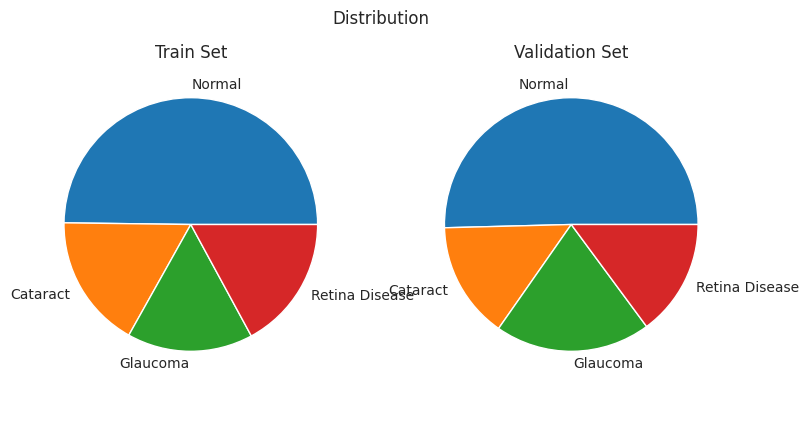

In [55]:
plot_pie_sets([y_train, y_val])

In [56]:
def create_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding="same", input_shape=[256, 256, 3]),
        MaxPooling2D(),
        Conv2D(64, (2, 2), padding="same", activation='relu'),
        MaxPooling2D(),
        Conv2D(64, (2, 2), padding="same", activation='relu'),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(4, activation='softmax')
    ])
    model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=['accuracy'])
    return model

In [57]:
model = create_model()
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 64)      8256      
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 64, 64, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 64)        16448     
                                                                 
 flatten_5 (Flatten)         (None, 262144)           

In [58]:
def strafied_kfold(model, X_train, y_train):
    # Define a StratifiedKFold object
    skf = StratifiedKFold(n_splits=6, shuffle=True, random_state=42)
    acc = []
    val_acc = []
    # Iterate over the K folds
    for train_index, test_index in skf.split(X_train, y_train):
        # Split the data into K folds
        X_fold_train, X_fold_test = X_train[train_index], X_train[test_index]
        y_fold_train, y_fold_test = y_train[train_index], y_train[test_index]

        # Train and evaluate the model on the fold
        history = model.fit(X_fold_train, y_fold_train, validation_data=(X_fold_test, y_fold_test), epochs=5)
        acc.append(history.history['accuracy'])
        val_acc.append(history.history['val_accuracy'])
    return model, acc, val_acc


In [59]:
model, acc, val_acc = strafied_kfold(model, X_train, y_train)
# Evaluate the model on the test set
y_pred = convertPreds(model.predict(x_val))
accuracy = accuracy_score(y_val, y_pred)
print(f'Test set accuracy: {accuracy:.2f}')


Epoch 1/5
38/38 [==============================] - 35s 905ms/step - loss: 352.7757 - accuracy: 0.3792 - val_loss: 1.3164 - val_accuracy: 0.5000
Epoch 2/5
38/38 [==============================] - 37s 969ms/step - loss: 1.2556 - accuracy: 0.4975 - val_loss: 1.2443 - val_accuracy: 0.5000
Epoch 3/5
38/38 [==============================] - 36s 936ms/step - loss: 1.2355 - accuracy: 0.4975 - val_loss: 1.2281 - val_accuracy: 0.5000
Epoch 4/5
38/38 [==============================] - 36s 941ms/step - loss: 1.2102 - accuracy: 0.5025 - val_loss: 1.2560 - val_accuracy: 0.5000
Epoch 5/5
38/38 [==============================] - 36s 938ms/step - loss: 1.1958 - accuracy: 0.5167 - val_loss: 1.2105 - val_accuracy: 0.5000
Epoch 1/5
38/38 [==============================] - 35s 932ms/step - loss: 1.1749 - accuracy: 0.5142 - val_loss: 1.2174 - val_accuracy: 0.5083
Epoch 2/5
38/38 [==============================] - 35s 911ms/step - loss: 1.1416 - accuracy: 0.5192 - val_loss: 1.2057 - val_accuracy: 0.5250
Epoc